In [2]:
import pickle
import numpy as np
from math import *

from scipy import spatial
import scipy.io as scio 
import os

import argparse

import numpy as np
import torch
import torch.nn as nn
import fnmatch

ModuleNotFoundError: No module named 'torch.nn'

In [2]:
a=scio.loadmat(os.getcwd()+'/'+"awa_demo_data.mat")

In [3]:
X_tr=a['X_tr']
X_te=a['X_te']
X_tr=NormalizeFea(X_tr.T,2).T

In [4]:
X_tr.shape, X_te.shape

((24295, 1024), (6180, 1024))

In [5]:
S_tr=a['S_tr']
S_te_pro=a['S_te_pro']
S_te_gt=a['S_te_gt']

Y_te=a['param']['test_labels'][0][0]
te_cl_id=a['param']['testclasses_id'][0][0]

In [6]:
S_tr.shape, S_te_pro.shape, S_te_gt.shape

((24295, 85), (10, 85), (10, 85))

In [7]:
S_te_pro[0], S_te_gt[0]

(array([47.51,  9.93,  0.  , 69.1 , 13.05,  7.14,  0.  ,  2.5 ,  0.62,
         0.  ,  0.  , 81.98,  0.46, 20.96, 28.29, 38.26,  6.56, 45.75,
         0.  , 77.77,  0.  ,  9.69,  9.31, 65.34,  2.5 , 54.26, 52.62,
        24.34, 11.84,  0.  ,  0.  , 14.44,  0.  , 49.83,  0.  , 10.31,
         3.75,  0.  , 59.72, 56.94, 15.42, 41.19, 17.27, 41.83, 66.82,
        44.53, 77.8 ,  7.5 ,  9.81,  0.  , 75.86,  2.5 ,  8.31,  0.  ,
        67.15, 22.28, 33.53, 11.94,  7.5 , 15.36,  0.  ,  8.75, 52.98,
        74.34,  1.25,  8.75,  5.  , 65.09, 15.58, 63.58,  0.  , 91.98,
        27.35,  0.  , 28.7 ,  1.25, 81.36, 10.  , 23.1 , 29.64, 84.36,
        74.51,  8.75, 41.93, 36.62]),
 array([47.51,  9.93,  0.  , 69.1 , 13.05,  7.14,  0.  ,  2.5 ,  0.62,
         0.  ,  0.  , 81.98,  0.46, 20.96, 28.29, 38.26,  6.56, 45.75,
         0.  , 77.77,  0.  ,  9.69,  9.31, 65.34,  2.5 , 54.26, 52.62,
        24.34, 11.84,  0.  ,  0.  , 14.44,  0.  , 49.83,  0.  , 10.31,
         3.75,  0.  , 59.72, 56.94, 15.

In [8]:
Y_te.shape, te_cl_id.shape

((6180, 1), (10, 1))

In [9]:
te_cl_id

array([[25],
       [39],
       [15],
       [ 6],
       [42],
       [14],
       [18],
       [48],
       [34],
       [24]], dtype=uint8)

In [10]:
lamb  = 500000;

W=SAE(X_tr.T,S_tr.T,lamb).T

In [11]:
S_te_est = X_te .dot(NormalizeFea(W,2))
dist     =  1 - spatial.distance.cdist(S_te_est,S_te_gt,'cosine')
#dist     = NormalizeFea(dist,0)
#[F --> S], projecting data from feature space to semantic space 
HITK=1
Y_hit5 =np. zeros((dist.shape[0],HITK))
for i in range(dist.shape[0]):
    I=np.argsort(dist[i])[::-1]
    Y_hit5[i,:]=np.squeeze(te_cl_id[I[0:HITK]])

n=0
for i in range(dist.shape[0]):
    if Y_te[i] in Y_hit5[i,:]:
        n=n+1

zsl_accuracy = n/dist.shape[0]
print(zsl_accuracy)   

0.8239482200647249


In [12]:
#[S --> F], projecting from semantic to visual space 
#dist    =  1 - zscore(pdist2(X_te, (S_te_pro * W'), 'cosine')) ;
S_te_pro=NormalizeFea(S_te_pro.T,2).T
dist     =  1 - spatial.distance.cdist(X_te,S_te_pro.dot(W.T),'cosine')

HITK=1
Y_hit5 =np. zeros((dist.shape[0],HITK))
for i in range(dist.shape[0]):
    I=np.argsort(dist[i])[::-1]
    Y_hit5[i,:]=te_cl_id[I[0:HITK]]

n=0
for i in range(dist.shape[0]):
    if Y_te[i] in Y_hit5[i,:]:
        n=n+1

zsl_accuracy = n/dist.shape[0]
print(zsl_accuracy) 

0.8577669902912621


In [13]:
X_te.shape, S_te_pro.dot(W.T).shape

((6180, 1024), (10, 1024))

In [60]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

class MultimodalDataset(Dataset):

    def __init__(self, vids, sem, transform=None):
        self.vids = vids
        self.caps = sem

    def __len__(self):
        return len(self.vids)

    def __getitem__(self, idx):
        vid_feat = self.vids[idx]
        word_feat = self.caps[idx]
        
        #word_feat = np.expand_dims(word_feat, axis=0)
        #label = vid_id.split("_")[0]
        
        '''
        
        neg_sample = False
        n_vid_id = vid_id
        n_label = label
        while not neg_sample:
            rand = randint(0, len(self.train_ids)-1)
            if rand == idx:
                break
            n_vid_id = self.train_ids[rand]
            n_label = n_vid_id.split("_")[0]
            if n_label is label:
                break
            neg_sample=True
        
        n_vid_feat = self.vids[n_vid_id]
        n_word_feat = self.caps[n_vid_id.split('_')[0]]
        n_word_feat = np.expand_dims(n_word_feat, axis=0)
        
        sample = {'vid_feat': vid_feat, 'word_feat': word_feat, 'label':label, 
                  'n_vid_feat': n_vid_feat, 'n_word_feat':n_word_feat, 'n_label':n_label }
        
        '''
        
        sample = {'vid_feat': vid_feat, 'word_feat': word_feat}
        return sample

    
batch_size=1024
train_data = MultimodalDataset(vids=X_tr[:22000], sem=S_tr[:22000])
val_data = MultimodalDataset(vids=X_tr[22000:25000], sem=S_tr[22000:25000])
#test_data = MultimodalDataset(test_ids, vids=vid_features, words=word_dict)
dataloaders_dict = {
    'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
    #'test': DataLoader(dataset=test_data, batch_size=1, shuffle=True)
}

In [27]:
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
#torch.cuda.set_device(3)
#torch.cuda.current_device()
device = torch.device('cuda:3')

In [61]:
from AE import *

In [89]:
C = 350 # mid bottleneck for video
N = 85 # representation dim
V = 1024 # feature vector size for vgg
L = 85 # mid bottleneck for text
D = 85 # gru feature size 

learning_rate = 1e-3
weight_decay = 1e-5
drop_out = 0.5

print("Video autoencoder::: ")
enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)

print("Word autoencoder::: ")
enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)

optim1 = torch.optim.Adam(enc_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim2 = torch.optim.Adam(dec_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim3 = torch.optim.Adam(enc_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim4 = torch.optim.Adam(dec_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.MSELoss()

Video autoencoder::: 
Word autoencoder::: 


In [19]:
device = torch.device('cpu:0')

In [90]:
enc_vid = enc_vid.to(device)
dec_vid = dec_vid.to(device)
enc_word = enc_word.to(device)
dec_word = dec_word.to(device)

#enc_vid = nn.DataParallel(enc_vid)
#dec_vid = nn.DataParallel(dec_vid)
#enc_word = nn.DataParallel(enc_word)
#dec_word = nn.DataParallel(dec_word)

In [64]:
best_enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
best_dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)

In [91]:
import time
import copy

since = time.time()

train_acc_history = []
val_acc_history = []

best_enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
best_dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)


best_loss = 1000000.0

num_epochs=150

for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            # Set model to training mode
            enc_vid.train()
            dec_vid.train()
            enc_word.train()
            dec_word.train()
        else:
            enc_vid.eval()
            dec_vid.eval()
            enc_word.eval()
            dec_word.eval()
            
        running_loss = 0.0
        l_recons, l_joint, l_cross = 0.0, 0.0, 0.0
        running_l_recons, running_l_joint, running_l_cross = 0.0, 0.0, 0.0
        running_l_rank = 0.0
        optim1.zero_grad()
        optim2.zero_grad()
        optim3.zero_grad()
        optim4.zero_grad()
        
        for data in dataloaders_dict[phase]:
            
            video = data["vid_feat"].float().to(device)
            word = data["word_feat"].float().to(device)
            
            #n_video = data["n_vid_feat"].float().to(device)
            #n_word = data["n_word_feat"].float().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                try:
                    mid_video = enc_vid(video)
                except RuntimeError as err:
                    print(video.shape)
                    print("mid video cannot create: ", err)
                    break
                out_video = dec_vid(mid_video)
                
                loss1 = criterion(out_video, video)

                mid_word = enc_word(word)
                out_word = dec_word(mid_word)

                
                loss2 = criterion(out_word, word)

                l_recons = loss1+loss2
                
                '''
                cos = nn.CosineSimilarity(dim=2, eps=1e-6)
                
                n_mid_word = enc_word(n_word)
                
                try:
                    sim1 = cos(mid_video, mid_word)
                    sim2 = cos(mid_video, n_mid_word)
                except:
                    break
                
                marg_loss = torch.nn.MarginRankingLoss(margin=0.2)
                target = torch.ones(len(sim1)).to(device)
                #print("mid word: ", mid_video.shape)
                #print("sim1: ", sim1.shape, " sim2: ", sim2.shape)
                l_rank_joint = marg_loss(sim1, sim2, target)
                '''
                
                l_joint = criterion(mid_video, mid_word)

                cross_words = dec_word(mid_video)
                cross_video = dec_vid(mid_video)
                l_cross = criterion(cross_words, word) + criterion(cross_video, video)

                alpha1, alpha2, alpha3 = 1, 0, 10
                
                loss = alpha1*l_recons + alpha2*l_joint + alpha3*l_cross
                
                running_loss += loss.item()
                running_l_recons += l_recons.item()
                running_l_joint += l_joint.item()
                running_l_cross += l_cross.item()
                #running_l_rank += l_rank_joint.item()

                if phase == 'train':
                    optim1.zero_grad()
                    optim2.zero_grad()
                    optim3.zero_grad()
                    optim4.zero_grad()
                    loss.backward()
                    optim1.step()
                    optim2.step()
                    optim3.step()
                    optim4.step()
            
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        
        if phase == 'train':
            train_acc_history.append(epoch_loss)
        
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_enc_vid = copy.deepcopy(enc_vid)
                best_dec_vid = copy.deepcopy(dec_vid)
                best_enc_word = copy.deepcopy(enc_word)
                best_dec_word = copy.deepcopy(dec_word)
            val_acc_history.append(epoch_loss)
            if epoch%25 ==0:
                print('epoch [{}/{}], epoch_loss:{:.8f}, l_recons:{:.8f}, l_joint:{:.8f}, l_rank:{:.8f}, l_cross:{:.8f}'
                      .format(epoch + 1, num_epochs, epoch_loss, running_l_recons, running_l_joint, 0, running_l_cross))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

torch.save(enc_vid.state_dict(), './video_encoder.pth')
torch.save(dec_vid.state_dict(), './video_decoder.pth')
torch.save(enc_word.state_dict(), './word_encoder.pth')
torch.save(enc_word.state_dict(), './word_decoder.pth')

epoch [1/150], epoch_loss:25782.83886719, l_recons:1488.97463989, l_joint:204.93194580, l_rank:0.00000000, l_cross:2429.38641357
epoch [26/150], epoch_loss:12737.53710938, l_recons:1154.10391235, l_joint:1.10089716, l_rank:0.00000000, l_cross:1158.34329224
epoch [51/150], epoch_loss:11613.81250000, l_recons:999.36926270, l_joint:1.60848197, l_rank:0.00000000, l_cross:1061.44430542
epoch [76/150], epoch_loss:8109.44775391, l_recons:639.24613953, l_joint:2.40672410, l_rank:0.00000000, l_cross:747.02014160
epoch [101/150], epoch_loss:8148.28222656, l_recons:602.25328064, l_joint:3.53371632, l_rank:0.00000000, l_cross:754.60290527
epoch [126/150], epoch_loss:8025.26782227, l_recons:593.07641602, l_joint:5.51570642, l_rank:0.00000000, l_cross:743.21913147
Training complete in 3m 2s
Best val Acc: 7682.438232


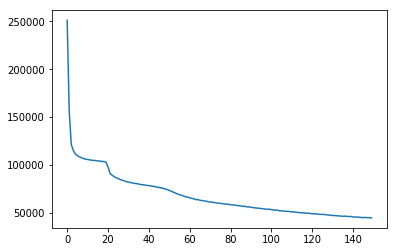

In [92]:
import matplotlib.pyplot as plt

plt.plot(train_acc_history)
plt.show()

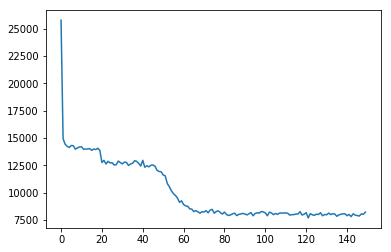

In [93]:
plt.plot(val_acc_history)
plt.show()

In [68]:
best_enc_vid.eval()
best_dec_vid.eval()
best_enc_word.eval()
best_dec_word.eval()

enc_vid.eval()
dec_vid.eval()
enc_word.eval()
dec_word.eval()

torch.set_grad_enabled(False)

unseen_loss=[]
S_te_est = []

for vis_emb in X_te:
    var = torch.from_numpy(vis_emb).float().to(device)
    mid_video = best_enc_vid(var)
    out_word = best_dec_word(mid_video)
    #print(mid_video)
    sample_word = out_word.cpu().detach().numpy()
    sample_word = np.squeeze(np.transpose(sample_word))
    S_te_est.append(sample_word)

In [69]:
len(S_te_est)

6180

In [49]:
y_set = set(np.asarray(Y_te))

TypeError: unhashable type: 'numpy.ndarray'

In [70]:
dist     =  1 - spatial.distance.cdist(S_te_est,S_te_gt,'cosine')
HITK=1
Y_hit5 =np. zeros((dist.shape[0],HITK))
for i in range(dist.shape[0]):
    I=np.argsort(dist[i])[::-1]
    Y_hit5[i,:]=np.squeeze(te_cl_id[I[0:HITK]])

n=0
for i in range(dist.shape[0]):
    #print(Y_hit5[i,:])
    if Y_te[i] in Y_hit5[i,:]:
        n=n+1

zsl_accuracy = n/dist.shape[0]
print(zsl_accuracy)  

0.3477346278317152


In [71]:
set(Y_te.flatten()), set(Y_hit5.flatten())
conf = {}
for y in set(Y_te.flatten()):
    for y_h in set(Y_hit5.flatten()):
        conf[(y, y_h)] = 0

In [72]:
for i in range(dist.shape[0]):
    #print(Y_te[i], Y_hit5[i,:])
    conf[(Y_te[i][0], Y_hit5[i,:][0])] += 1

In [73]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_te, Y_hit5)

In [74]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [75]:
cm2 = confusion_matrix(Y_te, Y_hit5)
print("label precision recall")
for label in range(10):
    print(f"{label:5d} {precision(label, cm2):9.3f} {recall(label, cm2):6.3f}")
    
print("precision total:", precision_macro_average(cm2))
print("recall total:", recall_macro_average(cm2))
print("accuracy:", accuracy(cm2))

label precision recall
    0     0.461  0.789
    1     0.775  0.548
    2     0.125  0.564
    3     0.923  0.906
    4     0.595  0.049
    5     0.111  0.001
    6     0.065  0.030
    7     0.000  0.000
    8     0.210  0.492
    9     0.000  0.000
precision total: 0.32642822838042707
recall total: 0.3379495113619734
accuracy: 0.3477346278317152


In [76]:
print("label precision recall")
for label in range(10):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")
    
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))

label precision recall
    0     0.461  0.789
    1     0.775  0.548
    2     0.125  0.564
    3     0.923  0.906
    4     0.595  0.049
    5     0.111  0.001
    6     0.065  0.030
    7     0.000  0.000
    8     0.210  0.492
    9     0.000  0.000
precision total: 0.32642822838042707
recall total: 0.3379495113619734


In [77]:
accuracy(cm)

0.3477346278317152

In [85]:
vis_est = []

for word_emb in S_te_gt:
    var = torch.from_numpy(word_emb).float().to(device)
    mid_word = best_enc_word(var)
    out_video = best_dec_vid(mid_word)
    sample_video = out_video.cpu().detach().numpy()
    sample_video = np.squeeze(np.transpose(sample_video))
    vis_est.append(sample_video)

In [86]:
len(vis_est[0])

1024

In [87]:
len(X_te), len(S_te_pro)

(6180, 10)

In [88]:
S_te_pro=NormalizeFea(S_te_pro.T,2).T
dist     =  1 - spatial.distance.cdist(X_te, vis_est,'cosine')

HITK=1
Y_hit5 =np. zeros((dist.shape[0],HITK))
for i in range(dist.shape[0]):
    I=np.argsort(dist[i])[::-1]
    Y_hit5[i,:]=np.squeeze(te_cl_id[I[0:HITK]])

n=0
for i in range(dist.shape[0]):
    if Y_te[i] in Y_hit5[i,:]:
        n=n+1

zsl_accuracy = n/dist.shape[0]
print(zsl_accuracy) 

0.3574433656957929


In [79]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA



pca = PCA(n_components=n_digits).fit(S_te_est)

In [80]:
reduced_data = PCA(n_components=2).fit_transform(S_te_est)
kmeans = KMeans(init='k-means++', n_clusters=10).fit_predict(reduced_data)

In [81]:
kmeans.shape

(6180,)

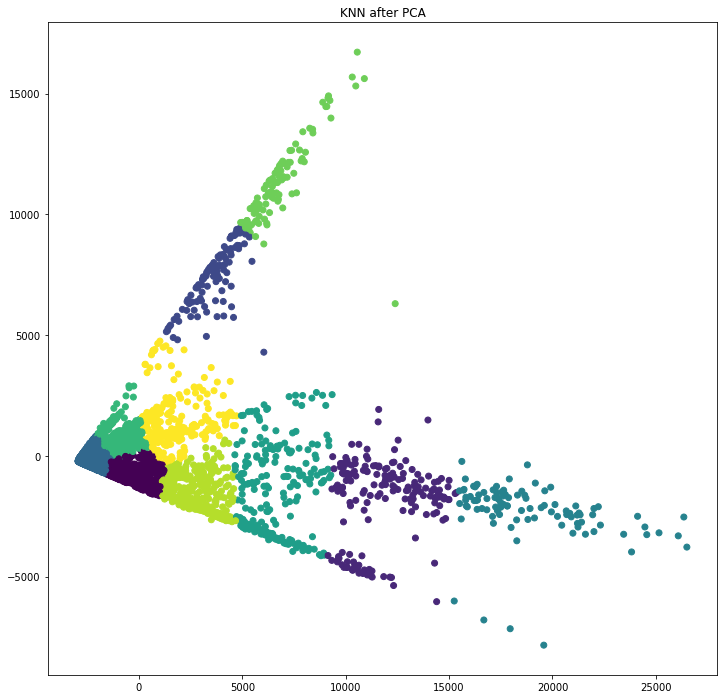

In [83]:
plt.figure(figsize=(12, 12))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans)
plt.title("KNN after PCA")

plt.show()

/home/r0734623/miniconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


ValueError: 'c' argument has 6180 elements, which is not acceptable for use with 'x' with size 1500, 'y' with size 1500.

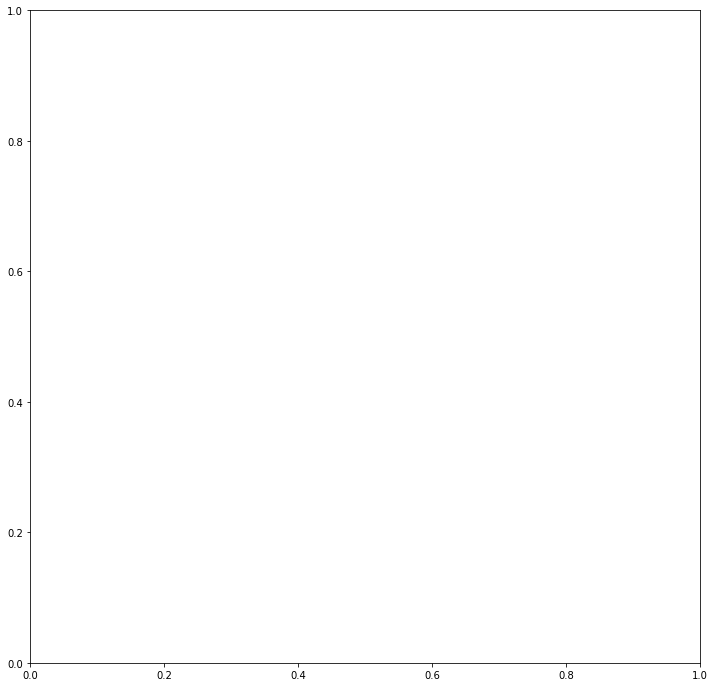

In [45]:


# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(pca)

plt.scatter(S_te_est[:, 0], S_te_est[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

plt.show()